# Prueba 1: Análisis de Sentimientos de Twitter

## PRELIMINARES

El ejercicio tiene por objetivo clasificar los sentimientos de tweets realizados en la red social Twitter, por lo tanto es un problema de clasificación. Para ello, se tiene una cantidad de sentimientos, los cuáles se deben re categorizar como sentimientos positivos o negativos. El problema consiste en que se tiene una serie de textos pertenecientes a estos tweets, los cuales deben ser analizados por el contenido de sus palabras, en donde la palabra será el atributo que nos permitirá predecir, mediante un modelo predictivo de clasificación, si el sentimiento es positivo o negativo en base al contenido del texto.

La solución al problema constará de un pre procesamiento, en donde se aplicará un vectorizador de textos, con el propósito de poder trabajar de mejor forma con las palabras contenidas. Luego, se va a definir cuáles son las palabras que más influyen en la predicción de los sentimientos y en base a estas se aplicarán los modelos de clasificación escogidos.

Los modelos de clasificación que se aplicarán para la resolución del problema son los siguientes:
* Naive Bayes.
* Regresión logística.
* Máquinas de soporte vectorial (SVC)
* Boosting Machines (GradientBoosting).
* Mecanismo de votación.

Para que estos modelos funcionen de una manera más óptima y mejorar sus métricas, se implementará una búsqueda de grilla y Pipeline con el propósito de encontrar los mejores hiper parámetros para cada modelo aplicado. Con esto y el pre procesamiento se espera optimizar el modelo implementado y escoger los dos que entreguen las mejores métricas.

Finalmente, las métricas serán la matriz de confusión, el reporte de clasificación con métricas de precision, recall y f1 score y la curva ROC.

## Hito 1: Aspectos Computacionales

In [1]:
# Importación de librerías básicas para el pre procesamiento y procesamiento de datos.
import pandas as pd                                                               ## v1.4.4
import numpy as np                                                                ## v1.23.5
import seaborn as sns                                                             ## v0.12.1
import matplotlib.pyplot as plt                                                   ## v3.6.2
import re
import random
random.seed(2208)

#Importación para la aplicación de modelos en SkLearn.
from sklearn.model_selection import train_test_split as TTS                       ## v1.0.2
from sklearn.model_selection import GridSearchCV                                  ## v1.0.2
from sklearn.preprocessing import StandardScaler                                  ## v1.0.2
from sklearn.feature_extraction.text import CountVectorizer                       ## v1.0.2
from sklearn.pipeline import Pipeline                                             ## v1.0.2
from sklearn.linear_model import LogisticRegression                               ## v1.0.2
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier         ## v1.0.2
from sklearn.naive_bayes import MultinomialNB                                     ## v1.0.2
from sklearn.svm import SVC                                                       ## v1.0.2

#Importación de métricas de desempeño de SkLearn para evaluar los modelos.
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

import pickle
import warnings
warnings.simplefilter("ignore")

Se importa la base de datos proporcionada con los tweets, para realizar el análisis:

In [2]:
df = pd.read_csv("training_tweets.csv").drop(columns="Unnamed: 0")
df

,content,sentiment
0,Happy Mama's day to all mothers,love
1,@LysdelTellez I am lost. Please help me find a...,worry
2,"@BoomKatt yes yes I AM, networking whore to th...",happiness
3,you@snapplynn Wish that would have been your t...,neutral
4,now i am doing the MicroEconomics project iha...,worry
...,...,...
29995,I do not want to work tomorrow!,sadness
29996,@KandyBee we shuld do a dance like that its s...,fun
29997,"Photo: Got my prints a few days ago, ready for...",happiness
29998,@tove_liden Thanks for the follow Tove!,fun


<AxesSubplot: xlabel='sentiment', ylabel='count'>

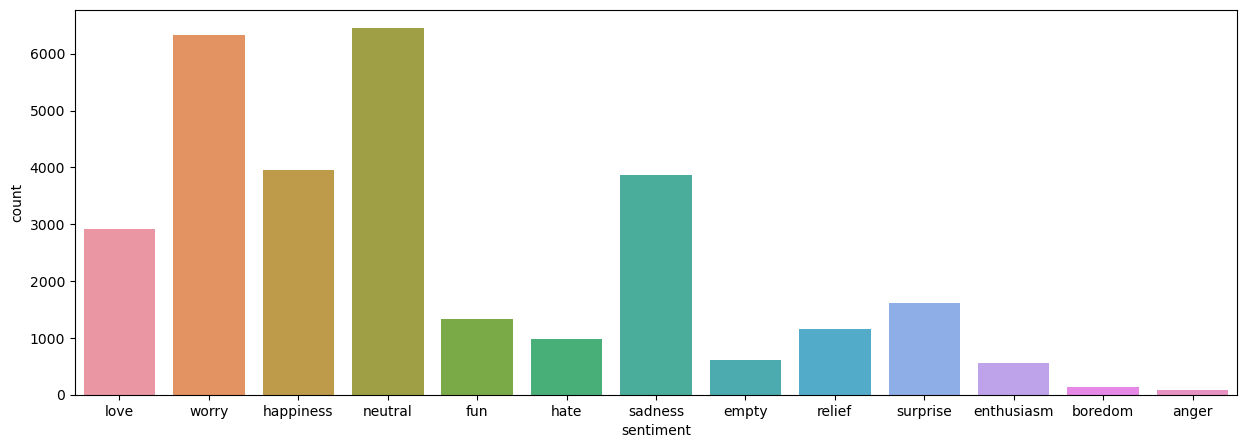

In [3]:
plt.figure(figsize=(15,5))
sns.countplot(x=df["sentiment"])

Se crea la variable sentiment_bin, asignando segun las indicaciones los valores "Positiva" y "Negativa" segun corresponda. Para el caso de valores "neutral", se asignan de manera aleatoria

In [4]:
positive = ["happiness", "love", "surprise", "fun", "relief", "enthusiasm"]
df["sentiment_bin"] = np.where(df["sentiment"].isin(positive), "Positiva", "Negativa")

df["sentiment_bin"] = np.where(df["sentiment"] == "neutral", random.choice(["Positiva", "Negativa"]), df["sentiment_bin"])

In [5]:
df["sentiment_bin"] = np.where(df["sentiment_bin"] == "Positiva", 1, 0)

   sentiment_bin
1          17978
0          12022


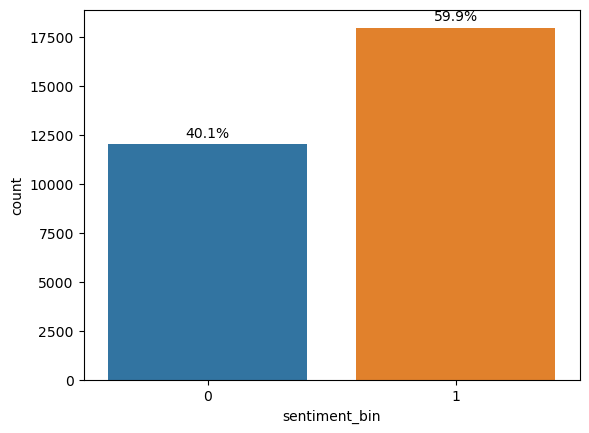

In [6]:
ax = sns.countplot(x=df["sentiment_bin"])
for p in ax.patches:
    height = p.get_height()
    ax.annotate("{:.1f}%".format(height*100/df["sentiment_bin"].shape[0]),
                xy=(p.get_x()+p.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center", va="bottom")
    
print(df["sentiment_bin"].value_counts().to_frame())

Se observa una desbalance de un 10% aproximadamente entre sentimientos Positivos y Negativos (proporcion ~ 60/40)

Se convierte a lower case los tweets.


In [7]:
df["content"] = df["content"].str.lower()
df

,content,sentiment,sentiment_bin
0,happy mama's day to all mothers,love,1
1,@lysdeltellez i am lost. please help me find a...,worry,0
2,"@boomkatt yes yes i am, networking whore to th...",happiness,1
3,you@snapplynn wish that would have been your t...,neutral,1
4,now i am doing the microeconomics project iha...,worry,0
...,...,...,...
29995,i do not want to work tomorrow!,sadness,0
29996,@kandybee we shuld do a dance like that its s...,fun,1
29997,"photo: got my prints a few days ago, ready for...",happiness,1
29998,@tove_liden thanks for the follow tove!,fun,1


Se analizan los datos perdidos

In [8]:
df.isnull().sum()

content          0
sentiment        0
sentiment_bin    0
dtype: int64

## Parametros de modelos seleciconados:

**Grilla Maquinas de Soporte Vectorial**
```python
    C: [0.001, 0.01, 0.1, 1, 10]
    gamma: [0.001, 0.01, 0.1, 1, 10]
    Validaciones cruzadas: 3.
```

**Naive Bayes**
```python
    alpha = [0.5, 1 ,2]
```

**GradientBoostingClassifier**
```python
    learning_rate: [0.01, 0.1, 0.5],
    n_estimators: [50, 100, 500, 1000, 2000]
    subsample: [0.1, 0.5, 0.9]
```
**LogisticRegression**
```python
    C: [0.01, 0.1, 1, 10, 100]
    fit_intercept: [True, False]
```
**Estimadores Voting**
```python
    estimators = [("Logistic Regression", LogisticRegression()),
                  ("SVM", SVC()),
                  ("Naive Bayes", MultinomialNB()),
                  ("Boosting Machine", GradientBoosting())]
```

In [9]:
def preprocess_string(string):
    string_holder = []
    tokenized_string = string.split(" ")
    for token in tokenized_string:
        token = token.lower()
        token = re.sub(re.compile("[^A-Za-z]+"), "", token)
        string_holder.append(token)
    return " ".join(string_holder)

In [10]:
import nltk
nltk.download('omw-1.4')
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from string import ascii_letters
nltk.download("averaged_perceptron_tagger")
from nltk.corpus import wordnet
nltk.download("wordnet")

def preprocess_string(string):
    string_holder = []
    tokenized_string = string.split(" ")
    for token in tokenized_string:
        token = token.lower()
        token = re.sub(re.compile("[^A-Za-z]+"), "", token)
        lemmatizer = WordNetLemmatizer()
        string_holder.append(lemmatizer.lemmatize(token))
    return " ".join(string_holder)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ltper\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ltper\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ltper\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ltper\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
count_vectorizer = CountVectorizer(max_features = 5000, stop_words="english", preprocessor=preprocess_string)
count_vectorizer_fit = count_vectorizer.fit_transform(df["content"])

## MODELACION

Se definen 2 conjuntos de entrenamiento y validación: 

1) Con el 20% de la data total para modelos complejos (SVM y GB).

2) Con toda la data para modelos mas simples (LogisticRegression, NB y Voting (con modelos ya definidos))

In [12]:
df_words = pd.DataFrame(count_vectorizer_fit.toarray(), columns = count_vectorizer.get_feature_names())


In [13]:
df_sample = pd.concat([df_words.reset_index(), df["sentiment_bin"].reset_index()], axis=1).sample(frac=0.2, random_state=2208).drop(columns="index")
X_train_20, X_test_20, y_train_20, y_test_20 = TTS(df_sample.drop(columns="sentiment_bin"), df_sample["sentiment_bin"], test_size=0.33, random_state=2208)
df_words


,aaaah,aaron,ab,abandoned,abby,abc,ability,abit,able,absolutely,...,zach,zack,zealand,zero,zoe,zombie,zone,zoo,ztnewetnorb,zune
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
X_train, X_test, y_train, y_test = TTS(df_words, df["sentiment_bin"], test_size=0.33, random_state=2208)

Primero se comienza asignando los parametros de cada grilla, luego se generan los modelos:

In [15]:
parametros_SVC = {"C": [0.001, 0.01, 0.1, 1, 10], 
                  "gamma": [0.001, 0.01, 0.1, 1, 10]}

parametros_NB = {"alpha": [0.5, 1, 2]}

parametros_GB = {"learning_rate": [0.01, 0.1, 0.5], 
                 "n_estimators": [50, 100, 500, 1000, 2000], 
                 "subsample": [0.1, 0.5, 0.9]}

parametros_LG = {"C": [0.01, 0.1, 1, 10, 100], 
                 "fit_intercept": [True, False]}

## 1) SVM

Como se mencionó anteriormente, este es un modelo complejo por lo que se utiliza el 20% de lo la base datos:

In [16]:
grilla_SVC = GridSearchCV(SVC(), param_grid=parametros_SVC, cv=3, n_jobs=-1, verbose=5)
grilla_SVC.fit(X_train_20, y_train_20)
y_SVC_predict = grilla_SVC.best_estimator_.predict(X_test_20)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [17]:
print("Mejores parámetros: ", grilla_SVC.best_params_)
print("Mejor puntaje     : ", grilla_SVC.best_score_)

Mejores parámetros:  {'C': 1, 'gamma': 0.1}
Mejor puntaje     :  0.6788557213930347


In [18]:
print(classification_report(y_test_20, y_SVC_predict))

              precision    recall  f1-score   support

           0       0.70      0.36      0.48       808
           1       0.67      0.90      0.77      1172

    accuracy                           0.68      1980
   macro avg       0.69      0.63      0.62      1980
weighted avg       0.68      0.68      0.65      1980



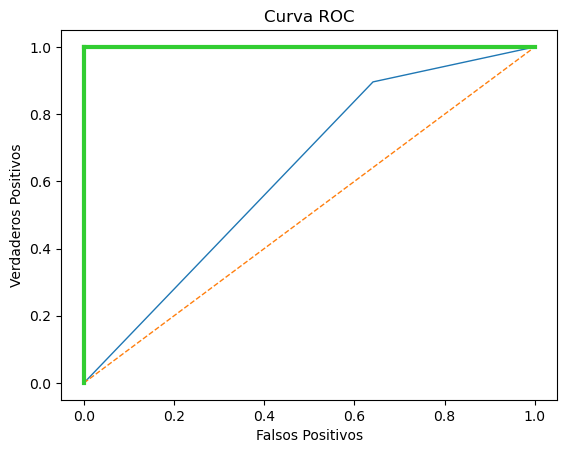

In [19]:
# Se grafica la curva ROC 
false_positive, true_positive, threshold = roc_curve(y_test_20, y_SVC_predict)

plt.title("Curva ROC")
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c="limegreen", lw=3), plt.plot([1, 1] , c="limegreen", lw=3)
plt.ylabel("Verdaderos Positivos")
plt.xlabel("Falsos Positivos");

## 2) LogisticRegresion

Modelo simple se ocupa toda la data:

In [20]:
grilla_LG = GridSearchCV(LogisticRegression(), 
                         param_grid=parametros_LG, 
                         cv=2,
                         n_jobs=-1,
                         verbose=5)
grilla_LG.fit(X_train, y_train)
y_LG_predict = grilla_LG.best_estimator_.predict(X_test)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


In [21]:
print("Mejores parámetros: ", grilla_LG.best_params_)
print("Mejor puntaje     : ", grilla_LG.best_score_)

Mejores parámetros:  {'C': 0.1, 'fit_intercept': True}
Mejor puntaje     :  0.7016915422885572


In [22]:
print(classification_report(y_test, y_LG_predict))

              precision    recall  f1-score   support

           0       0.70      0.46      0.56      3954
           1       0.71      0.87      0.78      5946

    accuracy                           0.71      9900
   macro avg       0.71      0.67      0.67      9900
weighted avg       0.71      0.71      0.69      9900



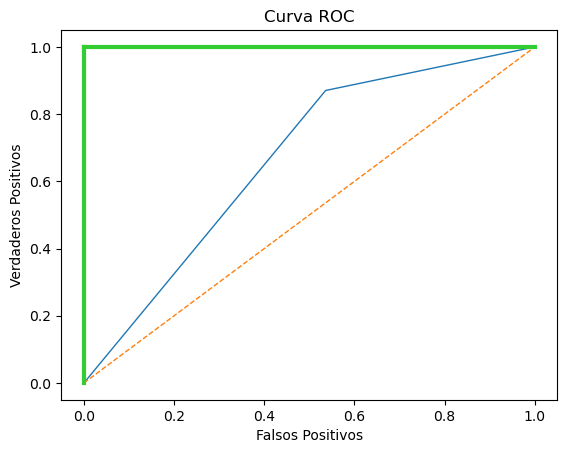

In [23]:
# Se grafica la curva ROC 
false_positive, true_positive, threshold = roc_curve(y_test, y_LG_predict)

plt.title("Curva ROC")
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c="limegreen", lw=3), plt.plot([1, 1] , c="limegreen", lw=3)
plt.ylabel("Verdaderos Positivos")
plt.xlabel("Falsos Positivos");

In [24]:
pickle.dump(grilla_SVC, open("grilla_SVC - Prueba Sentimientos Twitter.sav", "wb"))
pickle.dump(grilla_LG, open("grilla_LG - Prueba Sentimientos Twitter.sav", "wb"))
pickle.dump(X_train, open("X_train.sav - Prueba Sentimientos Twitter - Lucas Pereyra", "wb"))
pickle.dump(X_test, open("X_test.sav - Prueba Sentimientos Twitter - Lucas Pereyra", "wb"))
pickle.dump(y_train, open("y_train.sav - Prueba Sentimientos Twitter - Lucas Pereyra", "wb"))
pickle.dump(y_test, open("y_test.sav - Prueba Sentimientos Twitter - Lucas Pereyra", "wb"))

## 3) Naive Bayes

Este es un modelo mas simple, se utiliza el total de la data:

In [25]:
grilla_NB = GridSearchCV(MultinomialNB(), param_grid=parametros_NB, cv=5,n_jobs=-1, verbose=1)
grilla_NB.fit(X_train, y_train)
y_NB_predict = grilla_NB.best_estimator_.predict(X_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [26]:
print('Mejores parámetros: ', grilla_NB.best_params_)
print('Mejor puntaje     : ', grilla_NB.best_score_)

Mejores parámetros:  {'alpha': 2}
Mejor puntaje     :  0.7047263681592041


In [27]:
print(classification_report(y_test, y_NB_predict))

              precision    recall  f1-score   support

           0       0.65      0.59      0.61      3954
           1       0.74      0.79      0.76      5946

    accuracy                           0.71      9900
   macro avg       0.69      0.69      0.69      9900
weighted avg       0.70      0.71      0.70      9900



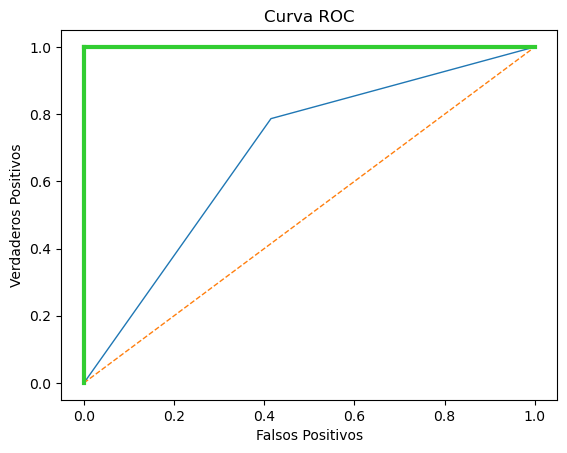

In [28]:
# Se grafica la curva ROC 
false_positive, true_positive, threshold = roc_curve(y_test, y_NB_predict)

plt.title('Curva ROC')
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] , c='limegreen', lw=3)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos');

## 4) GradientBoosting

Este en un modelo complejo por lo que se utiliza el 20% de la base de datos:

In [29]:
grilla_GB = GridSearchCV(GradientBoostingClassifier(), param_grid=parametros_GB, cv=5,n_jobs=-1, verbose=5)
grilla_GB.fit(X_train_20, y_train_20)
y_GB_predict = grilla_GB.best_estimator_.predict(X_test_20)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [30]:
print('Mejores parámetros: ', grilla_GB.best_params_)
print('Mejor puntaje     : ', grilla_GB.best_score_)

Mejores parámetros:  {'learning_rate': 0.1, 'n_estimators': 1000, 'subsample': 0.9}
Mejor puntaje     :  0.6880597014925373


In [31]:
print(classification_report(y_test_20, y_GB_predict))

              precision    recall  f1-score   support

           0       0.64      0.45      0.53       808
           1       0.69      0.82      0.75      1172

    accuracy                           0.67      1980
   macro avg       0.66      0.64      0.64      1980
weighted avg       0.66      0.67      0.66      1980



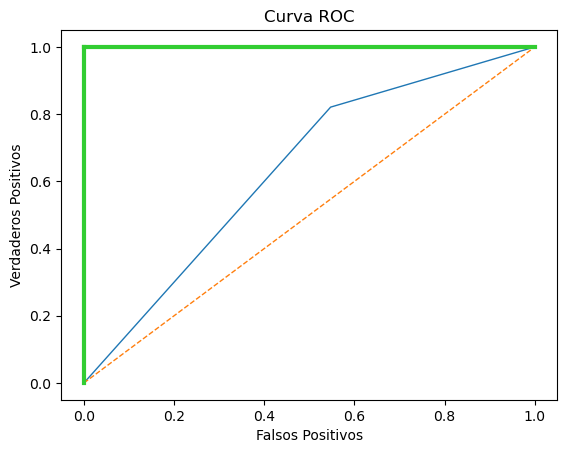

In [32]:
# Se grafica la curva ROC 
false_positive, true_positive, threshold = roc_curve(y_test_20, y_GB_predict)

plt.title('Curva ROC')
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] , c='limegreen', lw=3)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos');

## 5) VotingClassifier

Se genera un modelo Voting con los modelos generados anteriormente. Se incluye toda la base de datos para el entrenamiento:

In [33]:
estimators_VC = [('Logistic Regression', grilla_LG.best_estimator_), 
                 ('Naive Bayes', grilla_NB.best_estimator_),
                 #("GradientBoosting"), grilla_GB.best_estimator_,
                 ("SVC", grilla_SVC.best_estimator_)
                 ]

In [34]:
grilla_NB.best_estimator_

MultinomialNB(alpha=2)

In [35]:
modelo_VC = VotingClassifier(estimators_VC)
modelo_VC_fit = modelo_VC.fit(X_train, y_train)
y_VC_predict = modelo_VC_fit.predict(X_test)

In [36]:
print(classification_report(y_test, y_VC_predict))

              precision    recall  f1-score   support

           0       0.71      0.48      0.57      3954
           1       0.71      0.87      0.78      5946

    accuracy                           0.71      9900
   macro avg       0.71      0.67      0.68      9900
weighted avg       0.71      0.71      0.70      9900



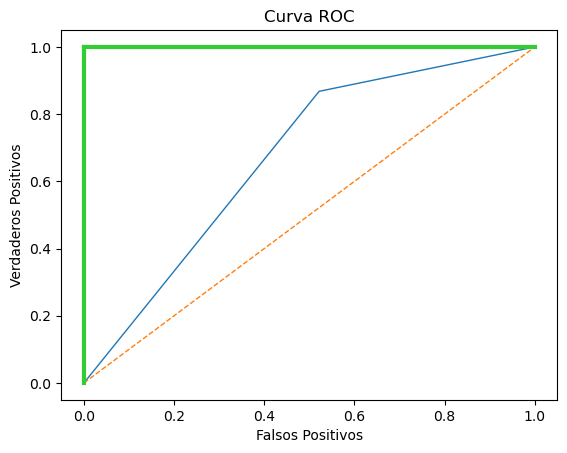

In [37]:
# Se grafica la curva ROC 
false_positive, true_positive, threshold = roc_curve(y_test, y_VC_predict)

plt.title('Curva ROC')
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] , c='limegreen', lw=3)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos');

In [38]:
print(classification_report(y_test_20, y_SVC_predict), "\n")
print(classification_report(y_test, y_LG_predict), "\n")
print(classification_report(y_test, y_NB_predict), "\n")
print(classification_report(y_test_20, y_GB_predict), "\n")
print(classification_report(y_test, y_VC_predict), "\n")

              precision    recall  f1-score   support

           0       0.70      0.36      0.48       808
           1       0.67      0.90      0.77      1172

    accuracy                           0.68      1980
   macro avg       0.69      0.63      0.62      1980
weighted avg       0.68      0.68      0.65      1980
 

              precision    recall  f1-score   support

           0       0.70      0.46      0.56      3954
           1       0.71      0.87      0.78      5946

    accuracy                           0.71      9900
   macro avg       0.71      0.67      0.67      9900
weighted avg       0.71      0.71      0.69      9900
 

              precision    recall  f1-score   support

           0       0.65      0.59      0.61      3954
           1       0.74      0.79      0.76      5946

    accuracy                           0.71      9900
   macro avg       0.69      0.69      0.69      9900
weighted avg       0.70      0.71      0.70      9900
 

             

In [39]:
import lec10_graphs as lec10

SVM
               precision    recall  f1-score   support

           0       0.70      0.36      0.48       808
           1       0.67      0.90      0.77      1172

    accuracy                           0.68      1980
   macro avg       0.69      0.63      0.62      1980
weighted avg       0.68      0.68      0.65      1980

Logistic Regression
               precision    recall  f1-score   support

           0       0.70      0.46      0.56      3954
           1       0.71      0.87      0.78      5946

    accuracy                           0.71      9900
   macro avg       0.71      0.67      0.67      9900
weighted avg       0.71      0.71      0.69      9900

Naive Bayes
               precision    recall  f1-score   support

           0       0.65      0.59      0.61      3954
           1       0.74      0.79      0.76      5946

    accuracy                           0.71      9900
   macro avg       0.69      0.69      0.69      9900
weighted avg       0.70      0.71  

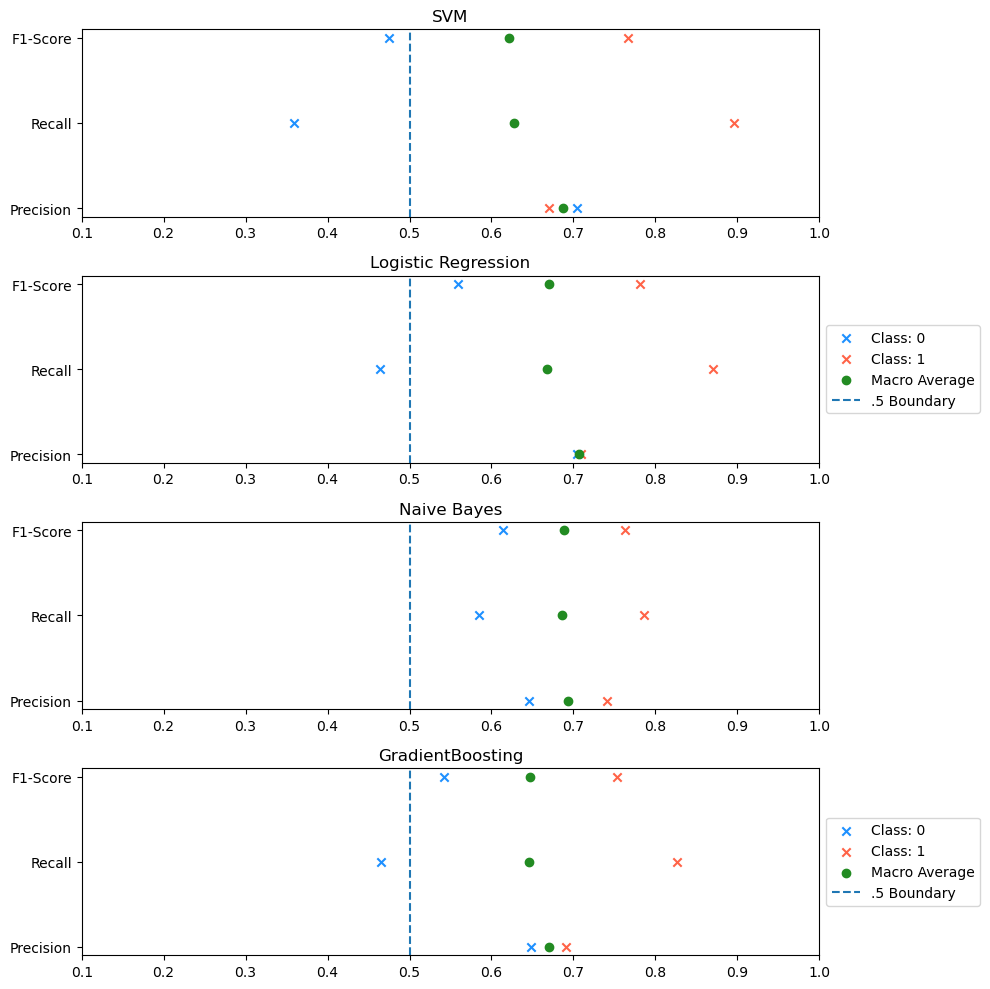

In [40]:
estimators = [("SVM", grilla_SVC.best_estimator_),
              ("Logistic Regression", grilla_LG.best_estimator_),
              ("Naive Bayes", grilla_NB.best_estimator_),
              ("GradientBoosting", grilla_GB.best_estimator_)]

plt.figure(figsize=(10, 10))

for index, value in enumerate(estimators):
    plt.subplot(len(estimators), 1, index + 1)
    plt.title(value[0])
    if value[0] == "SVM" or value[0] == "GradientBoosting":
        class_pred = value[1].fit(X_train_20, y_train_20).predict(X_test_20)
        lec10.plot_classification_report(y_test_20, class_pred)
        print(f"{value[0]}\n", classification_report(y_test_20, class_pred))        ## Agregué esta linea apra ver los valores numericos especificos
    else:
        class_pred = value[1].fit(X_train, y_train).predict(X_test)
        lec10.plot_classification_report(y_test, class_pred)
        print(f"{value[0]}\n", classification_report(y_test, class_pred))        ## Agregué esta linea apra ver los valores numericos especificos
    plt.axvline(.5, label=".5 Boundary", linestyle="--")
    plt.xlim((0.1, 1.0))
    if (index + 1) % 2 == 0:
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

## Iteración - SVM (muestras con 50% de los datos en vez del 20%)

El objetivo de esta iteracion es poder evaluar si al aumentar la cantidad de datos con la cual entrenamos nuestros modelos que previamente fueron castigados con el uso del 20% por temas de economia computacional, aumentaremos a un 50% de los datos y compararemos con los resultados anteriores y ver si vale la pena dicho aumento.

In [41]:
df_sample = pd.concat([df_words.reset_index(), df["sentiment_bin"].reset_index()], axis=1).sample(frac=0.5, random_state=2208).drop(columns="index")

X_train_50, X_test_50, y_train_50, y_test_50 = TTS(df_sample.drop(columns="sentiment_bin"), df_sample["sentiment_bin"], test_size=0.33, random_state=2208)


In [42]:
grilla_SVC_50 = GridSearchCV(SVC(), param_grid=parametros_SVC, cv=3, n_jobs=-1, verbose=5)
grilla_SVC_50.fit(X_train_50, y_train_50)
y_SVC_predict_50 = grilla_SVC_50.best_estimator_.predict(X_test_50)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [43]:
print("Mejores parámetros: ", grilla_SVC_50.best_params_)
print("Mejor puntaje     : ", grilla_SVC_50.best_score_)

Mejores parámetros:  {'C': 1, 'gamma': 0.1}
Mejor puntaje     :  0.6967164179104478


In [44]:
print(classification_report(y_test_50, y_SVC_predict_50))

              precision    recall  f1-score   support

           0       0.72      0.40      0.52      2009
           1       0.69      0.89      0.78      2941

    accuracy                           0.69      4950
   macro avg       0.70      0.65      0.65      4950
weighted avg       0.70      0.69      0.67      4950



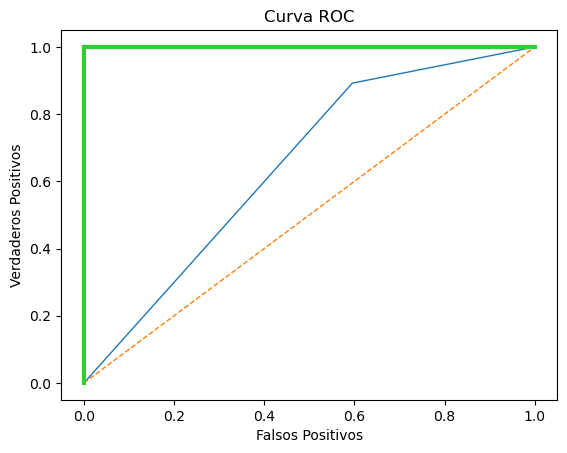

In [45]:
# Se grafica la curva ROC 
false_positive, true_positive, threshold = roc_curve(y_test_50, y_SVC_predict_50)

plt.title("Curva ROC")
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c="limegreen", lw=3), plt.plot([1, 1] , c="limegreen", lw=3)
plt.ylabel("Verdaderos Positivos")
plt.xlabel("Falsos Positivos");

## Iteración - GradientBoosting (muestras con 50% de los datos en vez del 20%)

In [46]:
grilla_GB_50 = GridSearchCV(GradientBoostingClassifier(), param_grid=parametros_GB, cv=5,n_jobs=-1, verbose=5)
grilla_GB_50.fit(X_train_50, y_train_50)
y_GB_predict_50 = grilla_GB_50.best_estimator_.predict(X_test_50)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [47]:
print('Mejores parámetros: ', grilla_GB_50.best_params_)
print('Mejor puntaje     : ', grilla_GB_50.best_score_)

Mejores parámetros:  {'learning_rate': 0.1, 'n_estimators': 500, 'subsample': 0.5}
Mejor puntaje     :  0.6975124378109452


In [48]:
print(classification_report(y_test_50, y_GB_predict_50))

              precision    recall  f1-score   support

           0       0.70      0.44      0.54      2009
           1       0.69      0.87      0.77      2941

    accuracy                           0.70      4950
   macro avg       0.70      0.65      0.66      4950
weighted avg       0.70      0.70      0.68      4950



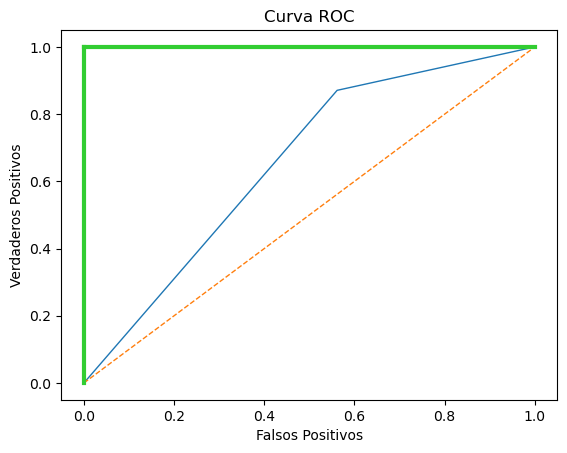

In [49]:
# Se grafica la curva ROC 
false_positive, true_positive, threshold = roc_curve(y_test_50, y_GB_predict_50)

plt.title('Curva ROC')
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] , c='limegreen', lw=3)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos');

SVM 20%
               precision    recall  f1-score   support

           0       0.70      0.36      0.48       808
           1       0.67      0.90      0.77      1172

    accuracy                           0.68      1980
   macro avg       0.69      0.63      0.62      1980
weighted avg       0.68      0.68      0.65      1980

SVM 50%
               precision    recall  f1-score   support

           0       0.72      0.40      0.52      2009
           1       0.69      0.89      0.78      2941

    accuracy                           0.69      4950
   macro avg       0.70      0.65      0.65      4950
weighted avg       0.70      0.69      0.67      4950

Logistic Regression
               precision    recall  f1-score   support

           0       0.70      0.46      0.56      3954
           1       0.71      0.87      0.78      5946

    accuracy                           0.71      9900
   macro avg       0.71      0.67      0.67      9900
weighted avg       0.71      0.71  

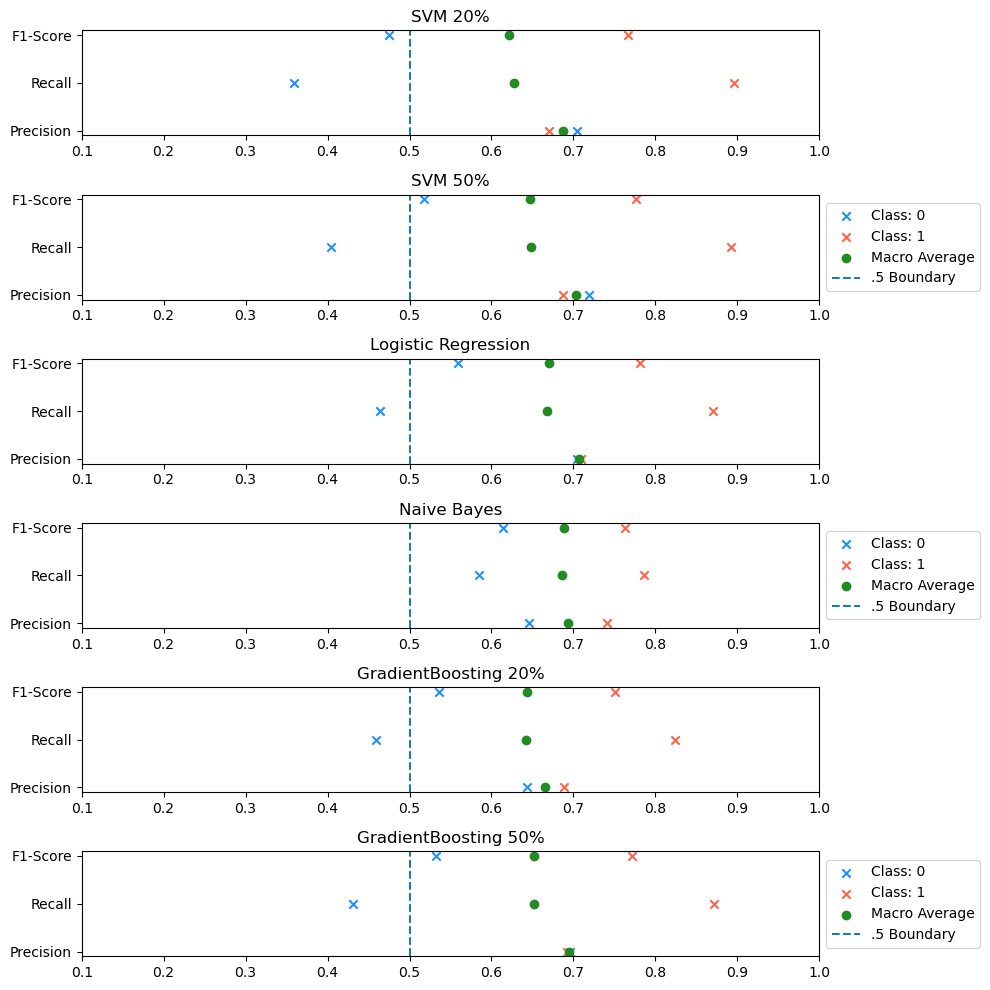

In [51]:
estimators = [("SVM 20%", grilla_SVC.best_estimator_),
              ("SVM 50%", grilla_SVC_50.best_estimator_),
              ("Logistic Regression", grilla_LG.best_estimator_),
              ("Naive Bayes", grilla_NB.best_estimator_),
              ("GradientBoosting 20%", grilla_GB.best_estimator_),
              ("GradientBoosting 50%", grilla_GB_50.best_estimator_)]

plt.figure(figsize=(10, 10))

for index, value in enumerate(estimators):
    plt.subplot(len(estimators), 1, index + 1)
    plt.title(value[0])
    if value[0] == "SVM 20%" or value[0] == "GradientBoosting 20%":
        class_pred = value[1].fit(X_train_20, y_train_20).predict(X_test_20)
        lec10.plot_classification_report(y_test_20, class_pred)
        print(f"{value[0]}\n", classification_report(y_test_20, class_pred))        ## Agregué esta linea apra ver los valores numericos especificos
    elif value[0] == "SVM 50%" or value[0] == "GradientBoosting 50%":
        class_pred = value[1].fit(X_train_50, y_train_50).predict(X_test_50)
        lec10.plot_classification_report(y_test_50, class_pred)
        print(f"{value[0]}\n", classification_report(y_test_50, class_pred))
    else:
        class_pred = value[1].fit(X_train, y_train).predict(X_test)
        lec10.plot_classification_report(y_test, class_pred)
        print(f"{value[0]}\n", classification_report(y_test, class_pred))        ## Agregué esta linea apra ver los valores numericos especificos
    plt.axvline(.5, label=".5 Boundary", linestyle="--")
    plt.xlim((0.1, 1.0))
    if (index + 1) % 2 == 0:
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

## Conclusión

Primero que todo, no se aprecia una mejora sustancial al aumentar la cantidad de datos en SVM y GB de 20% a 50%, por lo que si lo evaluamos desde el costo-beneficio, son mejores opciones las versiones con 20% por su menor costo computacional.
Dicho esto, y comparando todos los modelos anteriores, podemos considerar NB como uno de los mejores por su mejor equilibrio entre resultados de prediccion tanto para la clase 0 como 1. La otra opcion podria ser la Regresion Logistica, considerando su bajo costo computacional en comparacion al resto, y tiene valores muy similares al resto.

Finalmente los 2 modelos seleccionados son **Naive Bayes** y **Logistic Regresion**

In [52]:
#Modelo serializado
pickle.dump(grilla_NB, open('grilla_NB_fit.sav', 'wb'))
pickle.dump(grilla_LG, open('grilla_LG_fit.sav', 'wb'))
pickle.dump(X_train, open('X_train.sav', 'wb'))
pickle.dump(X_test, open('X_test.sav', 'wb'))
pickle.dump(y_train, open('y_train.sav', 'wb'))
pickle.dump(y_test, open('y_test.sav', 'wb'))
